# Mission - Analysez des images médicales avec des méthodes semi-supervisées

Vous êtes Data Scientist junior spécialisé en Computer Vision au sein de CurelyticsIA, une startup innovante dans le domaine de la e-santé. L’entreprise développe des solutions basées sur l’intelligence artificielle pour assister les professionnels de santé dans l’analyse d’images médicales, en particulier des IRM.
 
Dans le cadre d’un nouveau projet R&D, CurelyticsIA souhaite explorer la possibilité d’automatiser la détection de tumeurs du cerveau. Un ensemble conséquent de radios a été collecté : la majorité de ces images ne dispose d’aucun étiquetage, tandis qu’un sous-ensemble limité a été annoté par des radiologues experts.
 
Vous êtes chargé de concevoir une première exploration analytique du jeu de données. Plus précisément, votre mission est de :
- Explorer les images et extraire des caractéristiques visuelles via un modèle pré-entraîné ;
- Appliquer des méthodes de clustering pour identifier des structures ou regroupements dans les données ;
- Mettre en œuvre une méthode d’apprentissage semi-supervisé à partir des quelques étiquettes disponibles ;
- Synthétiser vos résultats, formuler des recommandations, et les présenter à votre équipe projet.

**Mail à prendre en compte :**

Comme discuté lors de notre dernière réunion, tu es assigné à la première phase du projet BrainScanAI. Tu trouveras en pièce jointe un fichier zip contenant :
- Le jeu de données de radiographies (en format PNG + métadonnées anonymisées),
- Une documentation technique sur le format des images ;
- Une liste restreinte de labels annotés par nos partenaires hospitaliers (normal/cancéreux). 

Pour info, notre budget actuel pour la labellisation par IA est de 300 euros pour ce dataset. 

Tes objectifs :
1) Extraire des caractéristiques visuelles pertinentes à l’aide d’un modèle pré-entraîné (type ResNet ou équivalent).
2) Réaliser un clustering exploratoire pour identifier des regroupements naturels.
3) Mettre en œuvre une méthode semi-supervisée en exploitant les labels partiels pour prédire les étiquettes manquantes.
4) Proposer des livrables au format Notebook contenant :
    - l’extraction des features
    - le preprocessing adapté au(x) modèle(s) utilisés
    - l’analyse non-supervisée (.ipynb)
    - l’entraînement de modèles de clustering
    - l’approche semi-supervisée (.ipynb)
 
Ces livrables doivent être accompagnés d’un support de présentation proposant des recommandations techniques pour un passage à l’échelle (budget de 5 000 euros pour 4 millions d’images à labelliser). Est-ce que ce passage te paraît faisable et si oui, sous quelles conditions ?

5) Rédiger une synthèse de ton approche et de tes résultats dans un support de présentation. Les contraintes :
    - Travailler en Python.
    - Tester plusieurs algorithmes.
    - Avoir des métriques pertinentes en fonction de l’erreur la plus importante (F1, Acc, Précision, ou autre ?).
    - Clairement définir ce que tu considères comme un objectif atteint (“definition of done”).


## Étape 4 - Appliquez une méthode semi supervisée

Entraîner un modèle de type CNN sur votre jeu de données “faiblement” labellisé dans un premier temps puis et évaluer ses performances. Poursuivez ensuite l’entraînement de ce même modèle sur le jeu de données “fortement” labellisé. Comparer ensuite la différence de performance entre entraînement supervisé (modèle entraîné sur le jeu de données “fortement” labellisé uniquement) et semi-supervisé (entraîné sur les 2 jeux de données).
 
**Prérequis**
- Avoir préparé un ensemble labellisé et un ensemble non labellisé

**Résultat attendu**
- Modèle entraîné et validé avec les métriques choisies (accuracy, F1-score ou autre ?)

**Recommandations**
- Réaliser un split train/test équilibré
- Pour chaque évaluation des performances: attention à ce que le jeu de test soir bien des données jamais vues par le modèle évalué lors de son entraînement.
- Utiliser des visualisations bien lisibles pour analyser les performances.

**Outils**
- Torchvision / TenforFlow / Transformers / Numpy / Pandas

## Importation des librairies

In [1]:
# Librairies de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librairies spécifiques
import os # permet de travailler avec le système de fichiers
from PIL import Image # ouvrir et manipuler des images
import glob

# Librairies PyTorch
import torchvision
import torch
from torchvision import transforms # pour effectuer les changements de format, entre autres
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Librairie pour l'early stopping
from early_stopping_pytorch import EarlyStopping

# Librairies Scikit-learn
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Choisit automatiquement GPU si disponible, sinon CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Enregistrement des dataset

In [2]:
# Chargement des chemins vers les images labellisées
# On suit l'ordre des fichiers csv enregistrés dans les autres notebook
cancer_paths = sorted(glob.glob("../mri_dataset_brain_cancer_oc/avec_labels/cancer/*"))
normal_paths = sorted(glob.glob("../mri_dataset_brain_cancer_oc/avec_labels/normal/*"))

# On regroupe les chemins
paths_labeled = cancer_paths + normal_paths

# Création des labels : 1 = cancer, 0 = normal
y_labeled = [1] * len(cancer_paths) + [0] * len(normal_paths)


# Chargement des pseudo-labels

pseudo_df = pd.read_csv("../data/processed/pseudo_labels.csv")

# On récupère les chemins des images non labellisées dans le même ordre
unlabeled_paths = sorted(glob.glob("../mri_dataset_brain_cancer_oc/sans_label/*"))

# Vérification de cohérence
assert len(unlabeled_paths) == len(pseudo_df), \
       "Erreur : nb d'images ≠ nb de pseudo-labels"

pseudo_labels = pseudo_df["pseudo_label"].values.tolist()

# Transformations à appliquer aux images

# Resize → Tensor → normalisation 0-1 / Afin de respecter le bon format

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Chargement effectif des images labellisées

print("Chargement des images labellisées...")

X_labeled = torch.stack([
    transform(Image.open(path).convert("RGB"))
    for path in paths_labeled
])

y_labeled = torch.tensor(y_labeled)

print(f"Images labellisées chargées : {X_labeled.shape}")


# Chargement des images avec pseudo-labels

print("Chargement des images pseudo-labellisées...")

X_unlabeled = torch.stack([
    transform(Image.open(path).convert("RGB"))
    for path in unlabeled_paths
])

pseudo_labels = torch.tensor(pseudo_labels)

print(f"Images pseudo-labellisées chargées : {X_unlabeled.shape}")


# Train/test split sur le dataset supervisé uniquement

X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(
    X_labeled,
    y_labeled,
    test_size=0.2,
    stratify=y_labeled,   # conserve le même ratio cancer/normal
    random_state=42
)

# Validation interne du train sur le dataset supervisé pour le early stopping
X_train_sup, X_val_sup, y_train_sup, y_val_sup = train_test_split(
    X_train_labeled,
    y_train_labeled,
    test_size=0.1,
    stratify=y_train_labeled,
    random_state=42
)

# Train/test split sur le dataset non labellisé uniquement
X_train_pseudo, X_val_pseudo, y_train_pseudo, y_val_pseudo = train_test_split(
    X_unlabeled,
    pseudo_labels,
    test_size = 0.2,
    random_state=42,
    stratify = pseudo_labels
)

print("\n Découpage terminé.")
print(f"Train supervisé : {X_train_labeled.shape}")
print(f"Test  supervisé : {X_test_labeled.shape}")


# Résumé global

print("\n RÉSUMÉ DES TENSEURS DISPONIBLES :")
print(f" X_train_labeled  : {X_train_labeled.shape}")
print(f" y_train_labeled  : {y_train_labeled.shape}")
print(f" X_test_labeled   : {X_test_labeled.shape}")
print(f" y_test_labeled   : {y_test_labeled.shape}")
print("----------------------------------------")
print(f" X_unlabeled      : {X_unlabeled.shape}")
print(f" pseudo_labels    : {pseudo_labels.shape}")
print("----------------------------------------")
print(f" X_train_sup    : {X_train_sup.shape}")
print(f" y_val_sup    : {y_val_sup.shape}")
print(f" X_val_sup    : {X_val_sup.shape}")
print(f" y_train_sup    : {y_train_sup.shape}")

Chargement des images labellisées...
Images labellisées chargées : torch.Size([100, 3, 224, 224])
Chargement des images pseudo-labellisées...
Images pseudo-labellisées chargées : torch.Size([1406, 3, 224, 224])

 Découpage terminé.
Train supervisé : torch.Size([80, 3, 224, 224])
Test  supervisé : torch.Size([20, 3, 224, 224])

 RÉSUMÉ DES TENSEURS DISPONIBLES :
 X_train_labeled  : torch.Size([80, 3, 224, 224])
 y_train_labeled  : torch.Size([80])
 X_test_labeled   : torch.Size([20, 3, 224, 224])
 y_test_labeled   : torch.Size([20])
----------------------------------------
 X_unlabeled      : torch.Size([1406, 3, 224, 224])
 pseudo_labels    : torch.Size([1406])
----------------------------------------
 X_train_sup    : torch.Size([72, 3, 224, 224])
 y_val_sup    : torch.Size([8])
 X_val_sup    : torch.Size([8, 3, 224, 224])
 y_train_sup    : torch.Size([72])


## Création de notre modèle CNN simple

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Première couche de convolution : 3 canaux RGB -> 32 / filtre 3x3 / détecte bords, intensités
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)

        # Pooling pour réduire la taille de l'image
        self.pool = nn.MaxPool2d(2,2)

        # Deuxième convolution : 32 -> 64 / filtre 3x3 / détecte formes plus larges
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Troisième convolution : 64 -> 128 / filtre 3x3 / détecte motifs médicaux
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Couche fully connected : calculée pour image 224*224 -> 28x28 après 3 poolings
        self.fc1 = nn.Linear(128 * 28 * 28, 256)

        # Dropout pour réduire l'overfitting / désactivation temporaire de neurones, ici 30%
        self.dropout = nn.Dropout(0.3)

        # Dernière couche : 256 -> 1 (classification binaire)
        self.fc2 = nn.Linear(256,1)

        # La fonction qui définit comment le modèle traite une image

    def forward(self, x):

        # Bloc 1 : conv -> relu -> pool
        x = self.pool(F.relu(self.conv1(x)))

        # Bloc 2
        x = self.pool(F.relu(self.conv2(x)))

        # Bloc 3
        x = self.pool(F.relu(self.conv3(x)))

        # Aplatit le tenseur 4D en 2D pour la couche fully connected
        x = x.view(x.size(0), -1)

        # Dense layer + dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Sortie sigmoïde pour une probabilité entre 0 et 1
        x = torch.sigmoid(self.fc2(x))
        return x

## Mise en place d'un Early Stopping pour éviter l'overfitting
* L'objectif va être de stopper l'entraînement du modèle avant que le modèle commence à "sur-apprendre"

In [4]:
class EarlyStopping:
    def __init__(self, patience=8, min_delta=0.0):
        # Nombre d'époques sans amélioration après lesquelles l'entraînement sera arrêté
        self.patience = patience
        # Changement minimum de la quantité surveillée pour être considéré comme une amélioration
        self.min_delta = min_delta
        # counter : nombre actuel d'époques sans amélioration
        self.counter = 0
        # best_loss : meilleure valeur du loss validé observée jusqu'à présent
        self.best_loss = None
        # best_model_state : sauvegarde des poids du meilleur modèle rencontré
        self.best_model_state = None
        # stop : indicateur booléen indiquant si l'entraînement doit être interrompu
        self.stop = False

    def __call__(self, val_loss, model):

        # Si c'est la première époque, on initialise la meilleure valeur de loss
        if self.best_loss is None:
            self.best_loss = val_loss
            # On sauvegarde l'état initial du modèle
            self.best_model_state = model.state_dict()
            return False

        # Si le loss de validation s'améliore suffisamment
        if val_loss < self.best_loss - self.min_delta:
            # On met à jour la meilleure valeur de loss
            self.best_loss = val_loss
            # On sauvegarde le meilleur état du modèle
            self.best_model_state = model.state_dict()
            # On réinitialise le compteur, puisqu'il y a amélioration
            self.counter = 0
            return False

        # Si pas d'amélioration
        else:
             # On incrémente le nombre d'époques sans amélioration
            self.counter += 1
            # Si on dépasse la patience : on arrête l'entraînement
            if self.counter >= self.patience:
                self.stop = True
                return True  # Arrêt immédiat

        return False


#### Création des dataloaders

In [5]:
# Batch size pour entraîner par petits lots
batch_size = 32

# Dataset supervisé (vrais labels) basé sur les données d'entraînement
dataset_sup_train = TensorDataset(X_train_sup, y_train_sup)

dataset_sup_val   = TensorDataset(X_val_sup,   y_val_sup)

# Dataset test (utilise le split test)
dataset_test = TensorDataset(X_test_labeled, y_test_labeled)

# Pseudo-labeled TRAIN dataset
dataset_pseudo = TensorDataset(X_train_pseudo, y_train_pseudo)

# Fine-tuning dataset (réel)
dataset_ft = TensorDataset(X_train_labeled, y_train_labeled)

# DataLoaders (chargent les données par batch)
loader_sup_train = DataLoader(dataset_sup_train, batch_size=batch_size, shuffle=True)

loader_sup_val   = DataLoader(dataset_sup_val,   batch_size=batch_size, shuffle=False)

loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

loader_pseudo = DataLoader(dataset_pseudo, batch_size=batch_size, shuffle=True)

loader_ft = DataLoader(dataset_ft, batch_size=batch_size, shuffle=True)

#### Entraînement supervisé - uniquement sur les données labellisées

In [6]:
def train_supervised(model, loader_train, loader_val, epochs=10, lr=1e-4):
    
    early_stopper = EarlyStopping(patience=8)
    model = model.to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for X, y in loader_train:

            X = X.to(device)
            y = y.float().to(device).view(-1, 1)

            optimizer.zero_grad()
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(loader_train)
        losses.append(avg_train_loss)

        # --- VALIDATION ---
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in loader_val:
                X = X.to(device)
                y = y.float().to(device).view(-1,1)
                val_loss += criterion(model(X), y).item()

        avg_val_loss = val_loss / len(loader_val)
        print(f"[SUP] Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

        if early_stopper(avg_val_loss, model):
            print("Early stopping triggered.")
            break

    # --- RECHARGER LES MEILLEURES POIDS ---
    model.load_state_dict(early_stopper.best_model_state)

    return model, losses


#### Pré-entraînement sur pseudo-labels - uniquement sur les données non labellisées

In [7]:
def pretrain_pseudo(model, loader, epochs=5, lr=1e-4):

    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for X, y in loader:

            X = X.to(device)
            y = y.float().to(device).view(-1, 1)
            
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            optimizer.step()

        print(f"[PSEUDO] Epoch {epoch+1}/{epochs}")

    return model


#### Fine-tuning sur vrais labels

In [8]:
def finetune(model, loader, epochs=20, lr=5e-5):

    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for X, y in loader:
            X = X.to(device)
            y = y.float().to(device).view(-1,1)
            
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            optimizer.step()

        print(f"[FINETUNE] Epoch {epoch+1}/{epochs}")

    return model

#### Évaluation

In [9]:
def evaluate(model, loader):
    model.eval()

    # probabilités
    probs = []
    # classes 0/1
    preds = []
    # y vrais
    truths = []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)

            # Le modèle renvoie des probabilités
            out = model(X).cpu().numpy().flatten()

            # On les garde pour AUC
            probs.extend(out.tolist())

            # On applique le seuil pour les métriques discrètes
            pred = (out >= 0.5).astype(int)
            preds.extend(pred.tolist())

            truths.extend(y.numpy().astype(int).tolist())

    acc = accuracy_score(truths, preds)
    f1 = f1_score(truths, preds)
    rec = recall_score(truths, preds)
    auc = roc_auc_score(truths, probs)

    return acc, f1, rec, preds, truths, auc


#### Modèle supervisé

In [10]:
model_sup = SimpleCNN()
model_sup, losses_sup = train_supervised(model_sup, loader_sup_train, loader_sup_val)
acc_sup, f1_sup, rec_sup, preds_sup, truths_sup, auc_sup = evaluate(model_sup, loader_test)

[SUP] Epoch 1/10 - Train Loss: 0.7197 - Val Loss: 0.6821
[SUP] Epoch 2/10 - Train Loss: 0.6771 - Val Loss: 0.6746
[SUP] Epoch 3/10 - Train Loss: 0.6641 - Val Loss: 0.6495
[SUP] Epoch 4/10 - Train Loss: 0.6327 - Val Loss: 0.6290
[SUP] Epoch 5/10 - Train Loss: 0.5802 - Val Loss: 0.6260
[SUP] Epoch 6/10 - Train Loss: 0.5777 - Val Loss: 0.6134
[SUP] Epoch 7/10 - Train Loss: 0.5289 - Val Loss: 0.5800
[SUP] Epoch 8/10 - Train Loss: 0.4914 - Val Loss: 0.5684
[SUP] Epoch 9/10 - Train Loss: 0.4937 - Val Loss: 0.5674
[SUP] Epoch 10/10 - Train Loss: 0.4074 - Val Loss: 0.5736


* La loss mesure l'erreur du modèle. On utilise ici la méthode BCELoss, qui va comparer la prédiction du modèle avec la vraie étiquette. 
* L'intuition, plus la loss est basse, plus la prédiction est proche de la vérité.
* Pendant l'entraînement, à chaque batch :
    * Le modèle fait une prédiction
    * La loss est calculée
    * Le gradient de la loss est propagé à travers le réseau (backpropagation)
    * L’optimizer (Adam) met à jour les poids
    * Ces poids deviennent un peu meilleurs

#### Modèle pseudo-labellisé

In [11]:
model_pseudo = SimpleCNN()
model_pseudo = pretrain_pseudo(model_pseudo, loader_pseudo)
acc_pseudo, f1_pseudo, rec_pseudo, preds_pseudo, truths_pseudo, auc_pseudo = evaluate(model_pseudo, loader_test)

[PSEUDO] Epoch 1/5
[PSEUDO] Epoch 2/5
[PSEUDO] Epoch 3/5
[PSEUDO] Epoch 4/5
[PSEUDO] Epoch 5/5


#### Modèe semi-supervisé complet

In [12]:
model_semi = SimpleCNN()
model_semi = pretrain_pseudo(model_semi, loader_pseudo)
model_semi, _ = train_supervised(model_semi, loader_sup_train, loader_sup_val)
acc_semi, f1_semi, rec_semi, preds_semi, truths_semi, auc_semi = evaluate(model_semi, loader_test)

[PSEUDO] Epoch 1/5
[PSEUDO] Epoch 2/5
[PSEUDO] Epoch 3/5
[PSEUDO] Epoch 4/5
[PSEUDO] Epoch 5/5
[SUP] Epoch 1/10 - Train Loss: 0.4889 - Val Loss: 0.3125
[SUP] Epoch 2/10 - Train Loss: 0.3920 - Val Loss: 0.3520
[SUP] Epoch 3/10 - Train Loss: 0.2889 - Val Loss: 0.4624
[SUP] Epoch 4/10 - Train Loss: 0.2872 - Val Loss: 0.4469
[SUP] Epoch 5/10 - Train Loss: 0.2413 - Val Loss: 0.4033
[SUP] Epoch 6/10 - Train Loss: 0.4741 - Val Loss: 0.4047
[SUP] Epoch 7/10 - Train Loss: 0.2246 - Val Loss: 0.4364
[SUP] Epoch 8/10 - Train Loss: 0.3841 - Val Loss: 0.4643
[SUP] Epoch 9/10 - Train Loss: 0.3739 - Val Loss: 0.4084
Early stopping triggered.


#### Tableau final comparatif

In [15]:
df_results = pd.DataFrame({
    "Méthode": ["Méthode supervisée", "Méthode semi-supervisée", "Méthode pseudo labellisée"],
    "Accuracy": [acc_sup, acc_semi, acc_pseudo],
    "F1": [f1_sup, f1_semi, f1_pseudo],
    "Recall": [rec_sup, rec_semi, rec_pseudo],
    "Auc": [auc_sup, auc_semi, auc_pseudo]
})

df_results

,Méthode,Accuracy,F1,Recall,Auc
0,Méthode supervisée,0.80,0.833333,1.0,0.75
1,Méthode semi-supervisée,0.85,0.857143,0.9,0.87
2,Méthode pseudo labellisée,0.85,0.842105,0.8,0.89


* On voit une amélioration avec la méthode semi-supervisée de la plupart des métriques.

### Matrice de confusion

#### Méthode supervisée

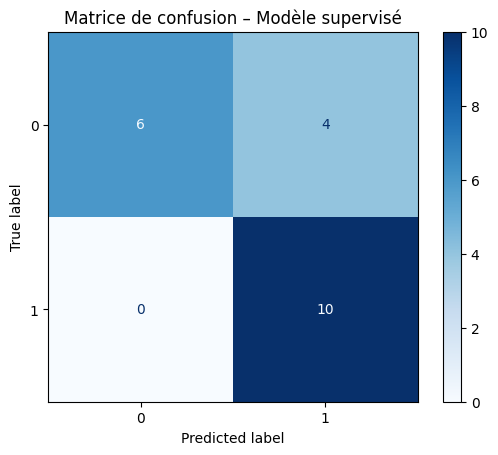

In [16]:
cm_sup = confusion_matrix(truths_sup, preds_sup)
disp_sup = ConfusionMatrixDisplay(cm_sup)
disp_sup.plot(cmap="Blues")
plt.title("Matrice de confusion – Modèle supervisé")
plt.show()

#### Méthode pseudo labellisée

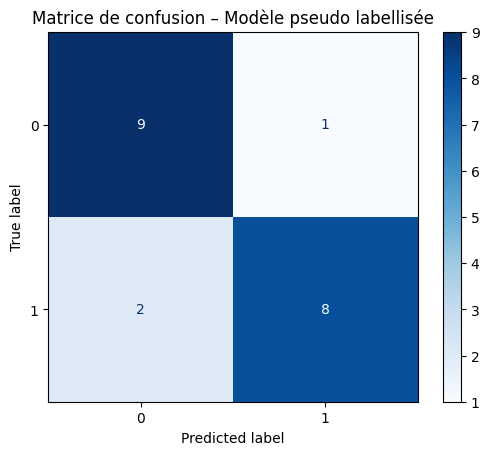

In [30]:
cm_pseudo = confusion_matrix(truths_pseudo, preds_pseudo)
disp_pseudo = ConfusionMatrixDisplay(cm_pseudo)
disp_pseudo.plot(cmap="Blues")
plt.title("Matrice de confusion – Modèle pseudo labellisée")
plt.show()

#### Méthode semi supervisée

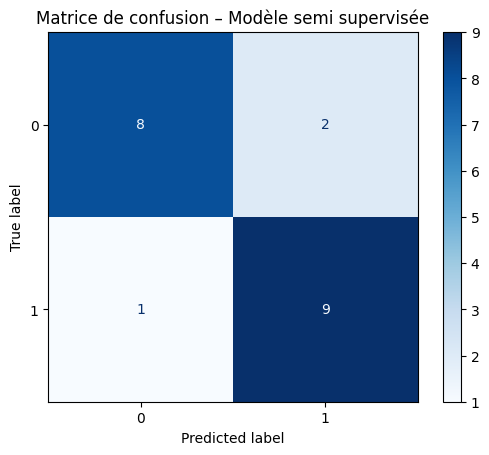

In [32]:
cm_semi = confusion_matrix(truths_semi, preds_semi)
disp_semi = ConfusionMatrixDisplay(cm_semi)
disp_semi.plot(cmap="Blues")
plt.title("Matrice de confusion – Modèle semi supervisée")
plt.show()

In [17]:
from sklearn.metrics import classification_report

print("==== SUPERVISÉ ====")
print(classification_report(truths_sup, preds_sup))


==== SUPERVISÉ ====
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.71      1.00      0.83        10

    accuracy                           0.80        20
   macro avg       0.86      0.80      0.79        20
weighted avg       0.86      0.80      0.79        20



In [34]:
print("==== PSEUDO LABEL ====")
print(classification_report(truths_pseudo, preds_pseudo))


==== PSEUDO LABEL ====
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.89      0.80      0.84        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



In [36]:
print("==== SEMI ====")
print(classification_report(truths_semi, preds_semi))


==== SEMI ====
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20

